In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.0 MB/s eta 0:00:00


In [ ]:
FILE_PATH = "/content/drive/MyDrive/DS Shared/DATA MAN/Articoli/articles.json"

import pandas as pd
articles = pd.read_json(FILE_PATH)

In [ ]:
from transformers import pipeline

sa_clf = pipeline('sentiment-analysis', model='soleimanian/financial-roberta-large-sentiment', device=0)

Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
sentences = articles['content'].explode().reset_index().rename({'index': 'article'}, axis=1)

In [ ]:
import torch

class ArticleDS(torch.utils.data.Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels

    def __getitem__(self, idx):
        return self.text[idx]

    def __len__(self):
        return len(self.labels)

In [ ]:
lens = sentences['content'].apply(lambda x: len(x))
over_sent = sentences[lens > 1024]
under_sent = sentences[lens <= 1024]

In [ ]:
import re
new_sent = over_sent.drop('content', axis=1).join(over_sent['content'].apply(lambda x: re.split(r'(?<=[a-z])\.(?=\s)', x)))

In [ ]:
new_sent = new_sent.explode('content')

In [ ]:
sentences_adj = pd.concat([under_sent, new_sent])

In [ ]:
import numpy as np
ds = ArticleDS(sentences_adj['content'].values, np.ones(len(sentences_adj)))

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

results = []

for out in tqdm(sa_clf(ds, batch_size=128, truncation="only_first"), total=len(ds)):
    results.append(list(out.values()))

  0%|          | 0/116492 [00:00<?, ?it/s]

In [ ]:
sa_df = pd.DataFrame(results, columns=['sent', 'score'])
final_df = sentences_adj.reset_index(drop=True).join(sa_df)

In [ ]:
final_df.to_json('sentences_final.csv')

In [ ]:
final_df = pd.read_json('/content/sentences_final.json')

In [ ]:
final_df.head()

,article,content,sent,score,sent_int,adj_sent
0,0,United States Senator Elizabeth Warren blamed ...,negative,0.984295,-1,-0.984295
1,0,While Senator Warren has prominently spoken ag...,negative,0.941911,-1,-0.941911
2,0,To help Warren rethink and make an informed de...,positive,0.978852,1,0.978852
3,0,"On the other hand, MicroStrategy founder and c...",neutral,0.948913,0,0.000000
4,0,#Bitcoin miners decrease the energy bill for m...,positive,0.981925,1,0.981925


In [ ]:
mapping = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}

final_df['sent_int'] = final_df['sent'].apply(lambda x: mapping[x])
final_df['adj_sent'] = final_df.sent_int * final_df.score

In [ ]:
articles_final = articles.join(final_df.groupby('article').mean(numeric_only=True)['adj_sent'])
articles_final.to_json('articles_final.json')

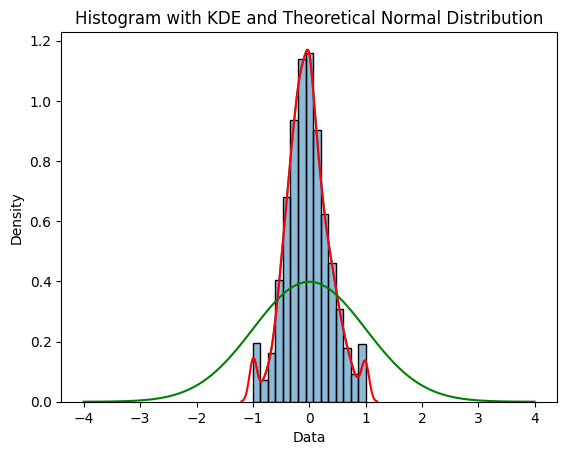

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Generate some random data
data = articles_final['adj_sent']

# Plot the histogram with KDE and normal distribution
sns.histplot(data, kde=True, stat="density", bins=15)
sns.kdeplot(data, color="r")
sns.lineplot(x=np.linspace(-4, 4, 100), y=np.exp(-np.square(np.linspace(-4, 4, 100))/2) / np.sqrt(2*np.pi), color="g")

# Set the plot title and labels
plt.title("Histogram with KDE and Theoretical Normal Distribution")
plt.xlabel("Data")
plt.ylabel("Density")

# Show the plot
plt.show()


In [ ]:
for i, art in enumerate(articles_final[articles_final.adj_sent > 0.9].title):
  print(art)
  if i > 10: break

CleanSpark boosts computing power by 37% with thousands of new Bitmain rigs
Bitcoin to the sky: Emirates to accept BTC payments and launch NFT collectibles
3.6M Americans to use crypto to make a purchase in 2022, research firm predicts
Tracked crypto donations to Ukraine surge to $108M as Kraken, Bored Ape joins in
AMC Entertainment CEO briefs community on crypto, NFT project updates in latest earnings call
Tourism in El Salvador up 30% since Bitcoin adoption, minister says
Bitmain signs 500MW joint venture with sustainable BTC miner Merkle Standard
NYDIG offering allows participating companies to pay employees in Bitcoin
Stacks ecosystem becomes #1 Web3 project on Bitcoin
3x NBA champion Andre Iguodala becomes the latest athlete to receive salary in crypto
MicroStrategy’s Saylor Integrates Bitcoin Lightning Address Into Corporate Email
Argentina’s National Securities Commission Approves Bitcoin Futures


In [ ]:
for i, art in enumerate(articles_final[articles_final.adj_sent < -0.9].title):
  print(art)
  if i > 10: break

Breaking: Bitcoin slips under $20K amid Biden budget, Silvergate collapse
Bitcoin and Ethereum correct amid Bitzlato takedown, tech layoffs and economic worries
Report: Vast majority of blockchain energy studies ’lack scientific rigor’
Indian police launch probe into BitConnect founder wanted by US SEC
Worst quarter in 11 years as Bitcoin price and activity plunge
CFTC brings $1.7B fraud case involving Bitcoin against South African national
Iranian government to cut power supply for the country's legal crypto mining rigs
RCMP asks crypto exchanges to halt trading for wallets connected to truck convoy protests
Tesla Made No Changes to Bitcoin Holdings in First Quarter
First Mover Asia: Chilly DOGE, While Bitcoin Simmers Over $28.6K
First Mover Asia: Bitcoin Extends Its Stay Below $28K, Dogecoin Stays Hot
U.S. Government Sold $216M of Seized Silk Road Bitcoin This Month


## Reddit

In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/DS Shared/DATA MAN/Reddit/REDDIT_finale.csv"
df = pd.read_csv(path)

In [ ]:
df.drop(['Unnamed: 0', 'index'], axis=1, inplace=True)
df.head()

,id,author,title,selftext,created_utc,subreddit,upvote_ratio,url,datetime
0,so9c6n,Williams_312,Stage5coin,NaN,1644398183,btc,1.00,https://www.reddit.com/r/btc/comments/so9c6n/s...,2022-02-09 09:00:00
1,so90yh,tylerJames1578,Marketing,NaN,1644396931,btc,1.00,https://www.reddit.com/r/btc/comments/so90yh/m...,2022-02-09 09:00:00
2,so8vty,MammothSir9,Russian govt and central bank agree to treat B...,NaN,1644396348,btc,1.00,https://www.reddit.com/r/btc/comments/so8vty/r...,2022-02-09 09:00:00
3,so8i2h,SoftRead7977,50 fee,"Hi, Yesterday ive tried to transfer the minim...",1644394708,btc,0.72,https://www.reddit.com/r/btc/comments/so8i2h/5...,2022-02-09 08:00:00
4,so8fa8,jkey34,BREAKING: Cryptocurrencies Will Be Treated As ...,NaN,1644394388,btc,0.63,https://coinbuzzfeed.com/bitcoin-and-other-cry...,2022-02-09 08:00:00


In [ ]:
df['selftext'][df.selftext.isna()] = ""
df['title'][df.title.isna()] = ""

<ipython-input-33-f7c3f766fe36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['selftext'][df.selftext.isna()] = ""
<ipython-input-33-f7c3f766fe36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title'][df.title.isna()] = ""


In [ ]:
idx = df['title'].str.len().sort_values().index
sorted_titles = df['title'].reindex(idx)

In [ ]:
import numpy as np

title_ds = ArticleDS(sorted_titles.values, np.ones(len(df)))

In [ ]:
from transformers.pipelines.pt_utils import KeyDataset
from tqdm.auto import tqdm

results = []

for out in tqdm(sa_clf(title_ds, batch_size=128, truncation="only_first"), total=len(title_ds)):
    results.append(list(out.values()))

  0%|          | 0/114644 [00:00<?, ?it/s]

In [ ]:
sa_df = pd.DataFrame(results, columns=['sent', 'score'])
title_sa_df = df.join(sa_df.set_index(idx))

In [ ]:
title_sa_df.head()

,id,author,title,selftext,created_utc,subreddit,upvote_ratio,url,datetime,sent,score
0,so9c6n,Williams_312,Stage5coin,,1644398183,btc,1.00,https://www.reddit.com/r/btc/comments/so9c6n/s...,2022-02-09 09:00:00,neutral,0.996448
1,so90yh,tylerJames1578,Marketing,,1644396931,btc,1.00,https://www.reddit.com/r/btc/comments/so90yh/m...,2022-02-09 09:00:00,neutral,0.986338
2,so8vty,MammothSir9,Russian govt and central bank agree to treat B...,,1644396348,btc,1.00,https://www.reddit.com/r/btc/comments/so8vty/r...,2022-02-09 09:00:00,positive,0.886648
3,so8i2h,SoftRead7977,50 fee,"Hi, Yesterday ive tried to transfer the minim...",1644394708,btc,0.72,https://www.reddit.com/r/btc/comments/so8i2h/5...,2022-02-09 08:00:00,neutral,0.996735
4,so8fa8,jkey34,BREAKING: Cryptocurrencies Will Be Treated As ...,,1644394388,btc,0.63,https://coinbuzzfeed.com/bitcoin-and-other-cry...,2022-02-09 08:00:00,neutral,0.999220


In [ ]:
idx = df['selftext'].str.len().sort_values().index
sorted_stext = df['selftext'].reindex(idx)
stext_ds = ArticleDS(sorted_stext.values, np.ones(len(df)))

In [ ]:
results = []

for out in tqdm(sa_clf(stext_ds, batch_size=128, truncation="only_first", max_length=512), total=len(stext_ds)):
    results.append(list(out.values()))

  0%|          | 0/114644 [00:00<?, ?it/s]

In [ ]:
sa_df = pd.DataFrame(results, columns=['sent', 'score'])
stext_sa_df = df.join(sa_df.set_index(idx))

In [ ]:
stext_sa_df.head()

,id,author,title,selftext,created_utc,subreddit,upvote_ratio,url,datetime,sent,score
0,so9c6n,Williams_312,Stage5coin,,1644398183,btc,1.00,https://www.reddit.com/r/btc/comments/so9c6n/s...,2022-02-09 09:00:00,positive,0.451683
1,so90yh,tylerJames1578,Marketing,,1644396931,btc,1.00,https://www.reddit.com/r/btc/comments/so90yh/m...,2022-02-09 09:00:00,positive,0.451683
2,so8vty,MammothSir9,Russian govt and central bank agree to treat B...,,1644396348,btc,1.00,https://www.reddit.com/r/btc/comments/so8vty/r...,2022-02-09 09:00:00,positive,0.451683
3,so8i2h,SoftRead7977,50 fee,"Hi, Yesterday ive tried to transfer the minim...",1644394708,btc,0.72,https://www.reddit.com/r/btc/comments/so8i2h/5...,2022-02-09 08:00:00,neutral,0.852529
4,so8fa8,jkey34,BREAKING: Cryptocurrencies Will Be Treated As ...,,1644394388,btc,0.63,https://coinbuzzfeed.com/bitcoin-and-other-cry...,2022-02-09 08:00:00,positive,0.451683


In [ ]:
all_sa = title_sa_df[['sent', 'score']].add_prefix('title_').join(stext_sa_df[['sent', 'score']].add_prefix('stext_'))
final_df = df.join(all_sa)

In [ ]:
mapping = {
    'positive': 1,
    'negative': -1,
    'neutral': 0
}

final_df['title_sent_int'] = final_df['title_sent'].apply(lambda x: mapping[x])
final_df['stext_sent_int'] = final_df['stext_sent'].apply(lambda x: mapping[x])

In [ ]:
mask = final_df.selftext.str.len() < 1
final_df.loc[mask, 'stext_sent_int'] = 0

In [ ]:
final_df['score'] = (final_df['title_score'] * final_df['title_sent_int'] + final_df['stext_score'] * final_df['stext_sent_int']) / 2
final_df.to_json('reddit.json')

In [ ]:
test = final_df[['created_utc', 'score']]

In [ ]:
test

,score
created_utc,
2022-02-09 09:16:23,0.000000
2022-02-09 08:55:31,0.000000
2022-02-09 08:45:48,0.443324
2022-02-09 08:18:28,0.000000
2022-02-09 08:13:08,0.000000
...,...
2022-12-20 00:36:30,0.493166
2022-12-20 00:33:18,-0.496551
2022-12-19 23:44:27,0.498979


In [ ]:
test['created_utc'] = pd.to_datetime(test['created_utc'], unit='s')

# Set the 'created_utc' column as the DataFrame's index
test.set_index('created_utc', inplace=True)

KeyError: ignored

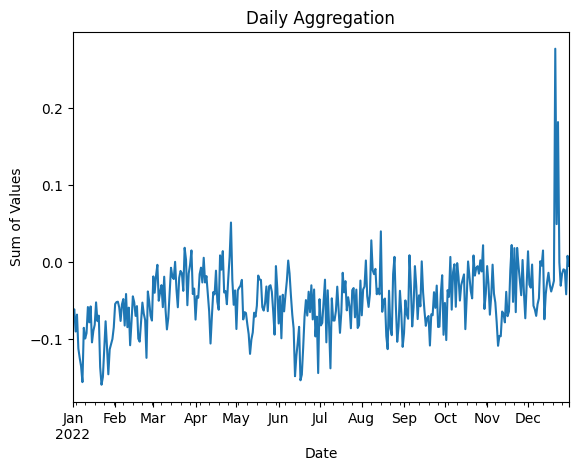

In [ ]:
import matplotlib.pyplot as plt
# Aggregate the data by day and compute the sum of the 'value' column
df_daily = test['score'].resample('D').mean()

# Plot the aggregated data
df_daily.plot()

# Add labels and title to the plot
plt.xlabel('Date')
plt.ylabel('Sum of Values')
plt.title('Daily Aggregation')

# Display the plot
plt.show()

In [ ]:
import yfinance as yf

# Download BTC price data for 2022
btc_data = yf.download('BTC-USD', start='2022-01-01', end='2022-12-31')

# Create a DataFrame
df = pd.DataFrame(btc_data)

# Print the DataFrame
print(df)

[*********************100%***********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2022-01-01  46311.746094  47827.312500  46288.484375  47686.812500   
2022-01-02  47680.925781  47881.406250  46856.937500  47345.218750   
2022-01-03  47343.542969  47510.726562  45835.964844  46458.117188   
2022-01-04  46458.851562  47406.546875  45752.464844  45897.574219   
2022-01-05  45899.359375  46929.046875  42798.222656  43569.003906   
...                  ...           ...           ...           ...   
2022-12-26  16842.250000  16920.123047  16812.369141  16919.804688   
2022-12-27  16919.291016  16959.845703  16642.072266  16717.173828   
2022-12-28  16716.400391  16768.169922  16497.556641  16552.572266   
2022-12-29  16552.322266  16651.755859  16508.683594  16642.341797   
2022-12-30  16641.330078  16643.427734  16408.474609  16602.585938   

               Adj C

In [ ]:
btc_ret = btc_data.pct_change().join(df_daily)
btc_ret_ma = btc_ret.rolling(30).mean()

<Axes: xlabel='Close', ylabel='score'>

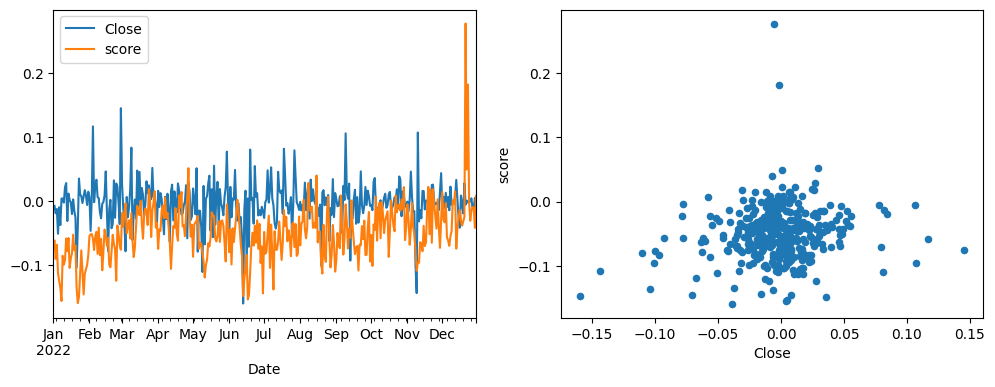

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
btc_ret[['Close', 'score']].plot(ax=ax[0])
btc_ret[['Close', 'score']].plot.scatter('Close', 'score', ax=ax[1])

<Axes: xlabel='Close', ylabel='score'>

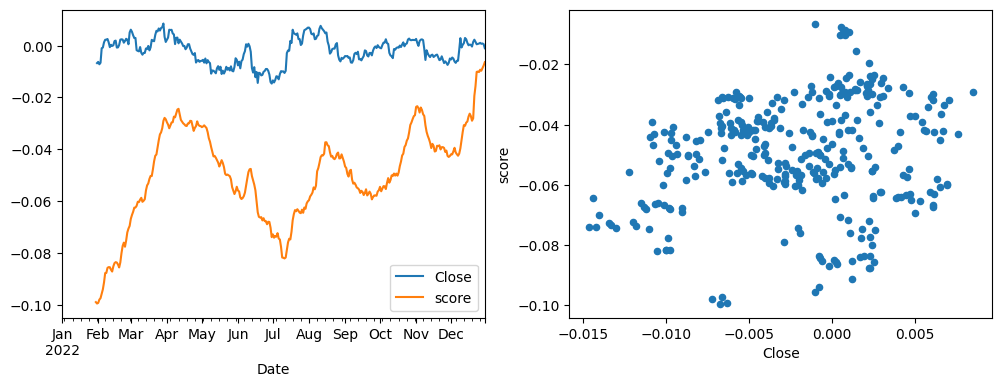

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
btc_ret_ma[['Close', 'score']].plot(ax=ax[0])
btc_ret_ma[['Close', 'score']].plot.scatter('Close', 'score', ax=ax[1])